<a href="https://colab.research.google.com/github/Tarleton-Math/data-science-20-21/blob/master/data_science_20_21_notes_10_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Decision Trees & Random Forests
## Class Notes 2020-10-20
## Data Science (masters)
## Math 5364 & 5366, Fall 20 & Spring 21
## Tarleton State University
## Dr. Scott Cook

In [1]:
! pip install --upgrade numpy
! pip install --upgrade pandas

Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.19.2)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.1.3)


Today we meet some new supervised algorithms, collectively called "Tree-Based" methods.

But first, recall the day 1 notes where we talked about "weak vs strong" learners and the [Wisdom of the Crowd](https://en.wikipedia.org/wiki/Wisdom_of_the_crowd).  The upshot that, is many cases, the combined prediction from many not-so-great sources is better than one great source.

One Decision Tree is a single not-so-great predictor.  We combined a bunch of them to form a much better "ensemble" predictor called a Random Forest.

## Decision Trees

https://scikit-learn.org/stable/modules/tree.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix

rng = np.random.RandomState(42)

data = load_iris()
# print(data.DESCR)
n, d = data.data.shape
X = pd.DataFrame(data.data, columns = data.feature_names)
y = pd.Series(data.target)

holdout_frac = 0.10
holdout_splitter = StratifiedShuffleSplit(n_splits=1, test_size=holdout_frac, random_state=rng)
model_idx, holdout_idx = next(holdout_splitter.split(X, y))
X_m, y_m = X.iloc[model_idx]  , y.iloc[model_idx]
X_h, y_h = X.iloc[holdout_idx], y.iloc[holdout_idx]
X_m.shape, X_h.shape

def display_results(grid, cutoff=1.0):
    res = grid.cv_results_
    df = pd.DataFrame(res['params'])
    df['score'] = (res['mean_test_score'] * 100)
    mask = df['score'] >= df['score'].max() * min(1-cutoff, 1)
    with pd.option_context('display.max_rows', 100, 'precision', 2):
        display(df[mask].sort_values('score', ascending=False))
    return df

def display_confusion_matrix(y_true, y_pred):
    """Pretty display for confusion matrix"""
    labels = y_true.unique()
    cf = confusion_matrix(y_true, y_pred, labels)
    acc = cf.trace() / cf.sum() * 100
    df = pd.DataFrame(cf, columns=labels, index=labels)
    df.index.name = 'Actual'
    df.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    plt.title(f'accuracy={acc:.2f}%')
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
    plt.show()
    return df

In [2]:
import pydotplus
import graphviz
from IPython.display import Image  
def viz_tree(tree, feat_names, targ_names):
    dot_data = tree.export_graphviz(clf, out_file=None, 
                                    feature_names=feat_names,  
                                    class_names=targ_names,  
                                    filled=True, rounded=True,  
                                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    display(Image(graph.create_png(), width=800))

For a moment, let's skip cross-validation.  It'll be easier to focus on learning about decision trees without the complexity cv brings.  But, we always need to do cv when building a real model.

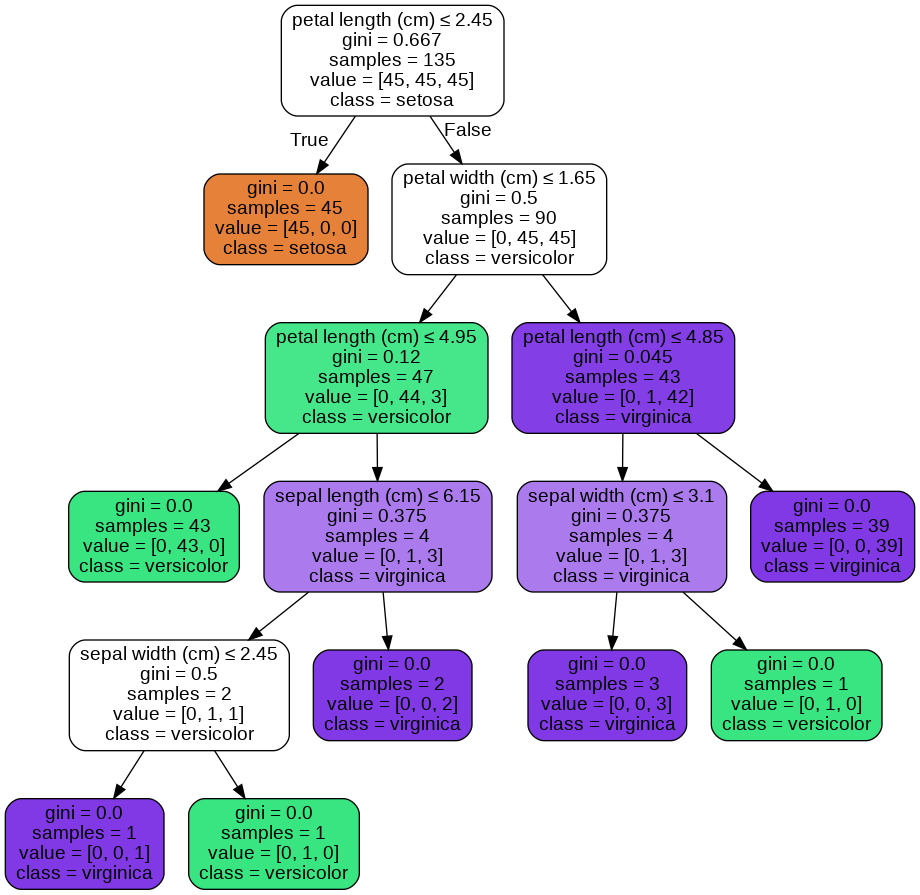

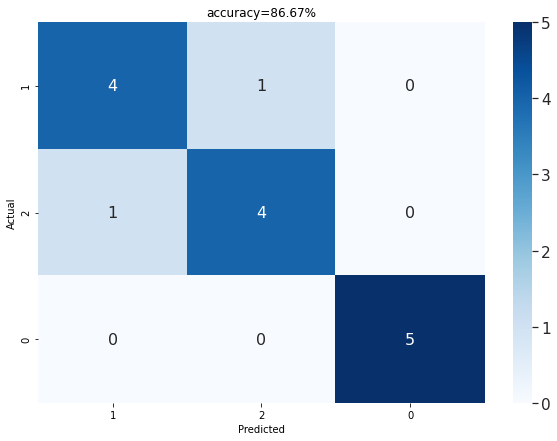

In [3]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_m, y_m)
viz_tree(tree, X_m.columns, data.target_names)
display_confusion_matrix(y_h, clf.predict(X_h));

Let's try a little dimensionality reduction

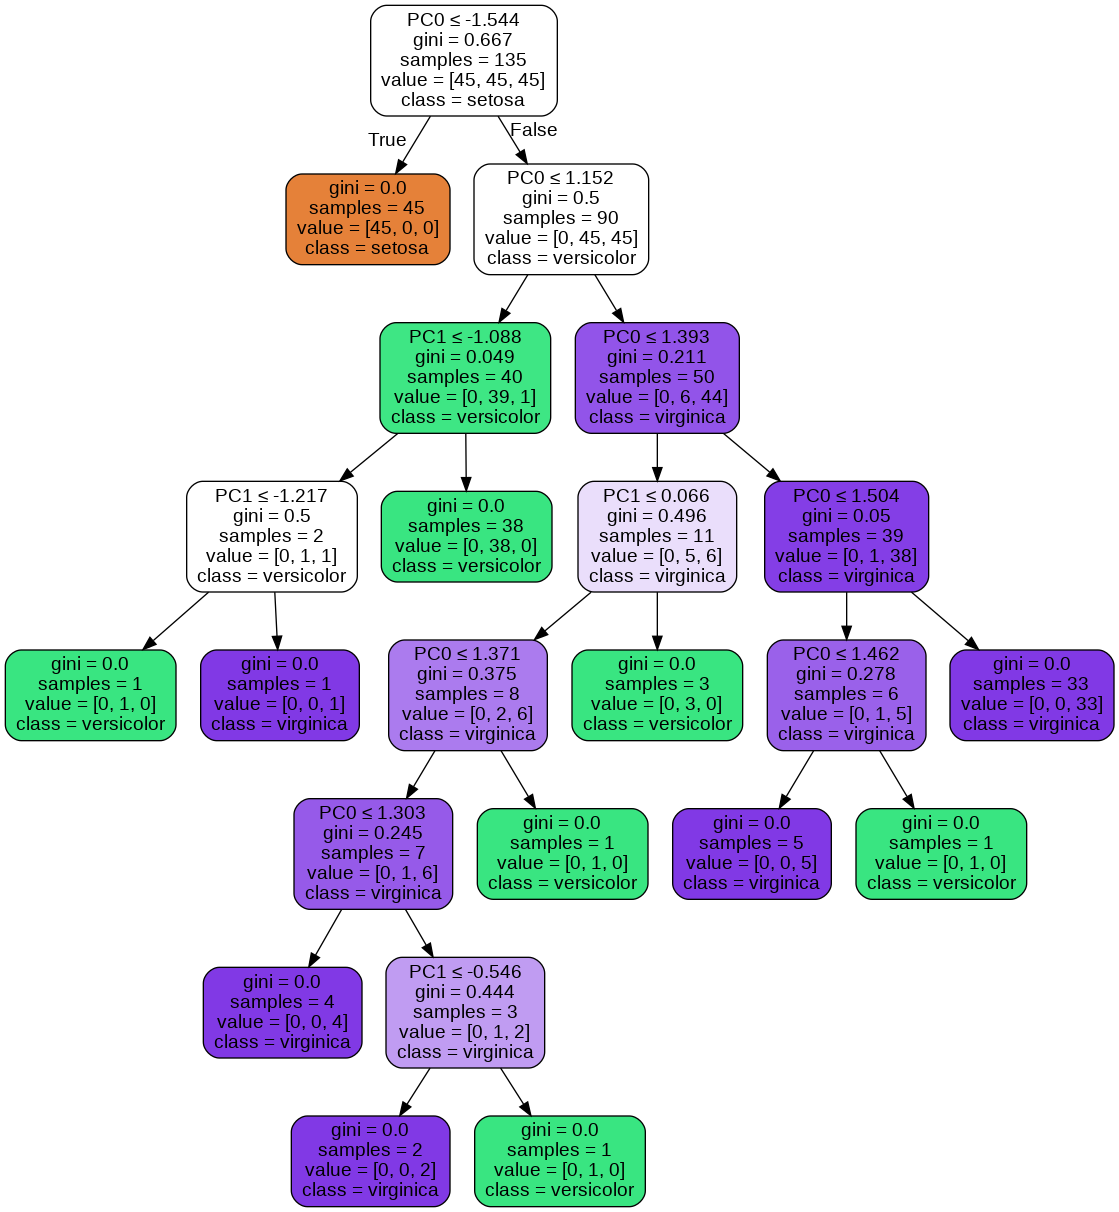

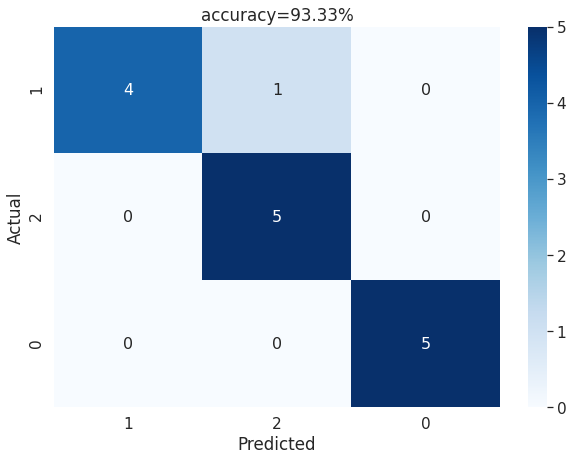

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X_m)
cols = [f"PC{i}" for i in range(pca.n_components)]
X_m_pca = pd.DataFrame(pca.transform(X_m), columns=cols)
X_h_pca = pd.DataFrame(pca.transform(X_h), columns=cols)
clf = clf.fit(X_m_pca, y_m)
viz_tree(tree, X_m_pca.columns, data.target_names)
display_confusion_matrix(y_h, clf.predict(X_h_pca));

Now that we're in 2 dimensions, we can visualize things like the *decision boundary*.

We'll modify code from https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html

Automatically created module for IPython interactive environment


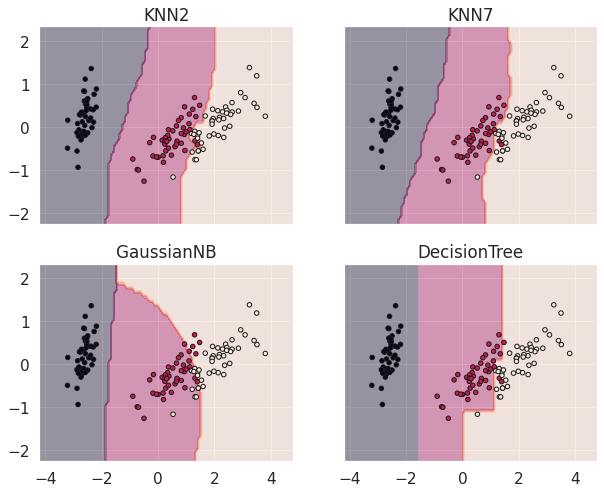

In [30]:
from itertools import product

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
XP = X_m_pca.values

# Training classifiers
clf1 = KNeighborsClassifier(n_neighbors=2)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = GaussianNB()
clf4 = DecisionTreeClassifier(max_depth=4)

names = ['KNN2', 'KNN7', 'GaussianNB', 'DecisionTree']

clf1.fit(XP, y_m)
clf2.fit(XP, y_m)
clf3.fit(XP, y_m)
clf4.fit(XP, y_m)

# Plotting decision regions
x_min, x_max = XP[:, 0].min() - 1, XP[:, 0].max() + 1
y_min, y_max = XP[:, 1].min() - 1, XP[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, clf4],
                        names):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(XP[:, 0], XP[:, 1], c=y_m,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html